In [2]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, \
    init_to_uniform, init_to_value

from pymc3.gp.util import plot_gp_dist
import pymc3 as pm
# import pymc3.sampling_jax

import pandas as pd
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import cmdstanpy as stan
import seaborn as sns
import arviz as az

from tqdm import tqdm

In [3]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [4]:
# Default to double precision.
numpyro.enable_x64()

# Utility models

In [5]:
def u_pow(x, theta): return x**theta

In [6]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [7]:
def u_lin(x, theta=None): return x

# Generate choice data

In [8]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [9]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [10]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [11]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [12]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Measure discrepancy

## Generate data

In [13]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [14]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=100, replace=False)

In [15]:
optimize(data, u_m=u_pow)

array([3.4444072 , 0.39557323])

## Using Scipy (MLE)

In [81]:
def sofplus(x):
    return np.log(1 + np.exp(x))

In [82]:
def kernel(X, Xs, length):
    deltaX = np.power((X[:, None] - Xs) / length, 2.0)
    return np.exp(-0.5 * deltaX)

In [83]:
def model(X, p, y, tau, factor, M, undo_sorted, jitter=1e-06):
    
    n_x = X.shape[0]
    n_y = y.shape[0]
    
    def objective(param):

        var = softplus(param[0])
        length = sofplus(param[1])
        eta = param[2:]

        K = factor * var**2 * kernel(X, X, length) + jitter * np.eye(n_x)
        L = np.linalg.cholesky(K)
        f = M + L.dot(eta)

        est_eu_sorted =  p * f    
        est_eu = est_eu_sorted[undo_sorted]
        est_diff_eu = est_eu[n_y:] - est_eu[:n_y]
        
        p_y = scipy.special.expit(tau*est_diff_eu)
        log_p = np.log(p_y**y * (1-p_y)**(1-y) + np.finfo(float).eps).sum()
        
        return - log_p
        #numpyro.sample("obs", dist.Bernoulli(logits=), obs=y)
    
    return objective

In [84]:
def run_inference(data, u, theta, tau, use_ratio):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    X = x_sorted
    uX = u(X, theta)
    P = p_sorted

    M = uX
    
    if use_ratio:
        factor = uX[:, None] * uX
    else:
        factor = 1.
        
    res = scipy.optimize.minimize(
        model(X=X, p=P, y=y, tau=tau, factor=factor, M=M, undo_sorted=undo_sorted),
        x0=np.zeros(2+len(X)))
    
    opt_var = sofplus(res.x[0])
    opt_length = sofplus(res.x[1])
    opt_eta = res.x[2:]
    
    return X, opt_var, opt_length, opt_eta

In [89]:
def gp_predict(X, var, length, eta, u, theta, use_ratio, Xnew=None, jitter=1.0e-6):
    
    '''
    Close to: https://github.com/pymc-devs/pymc3/blob/master/pymc3/gp/gp.py
    '''
    
    uX = u(X, theta)
    
    N = X.shape[0]
    if use_ratio:
        factor = uX[:, None] * uX
    else:
        factor = 1
        
    K_XX = factor * var**2 * kernel(X, X, length) + jitter*np.eye(N)
    L = np.linalg.cholesky(K_XX)
    f = uX + L.dot(eta)
    
    if Xnew is not None:
        M = Xnew.shape[0]
        
        up = u(Xnew, theta)
        if use_ratio:
            factor_Xp = uX[:, None] * up
        else:
            factor_Xp = 1
        
        K_Xp = factor_Xp * var**2 * kernel(X, Xnew, length)
        
        A = scipy.linalg.solve_triangular(L, K_Xp, lower=True)
        v = scipy.linalg.solve_triangular(L, f - uX, lower=True)
        
        f_predict = up + A.T.dot(v)
        
        if use_ratio:
            factor_pp = up[:, None] * up
        else:
            factor_pp = 1 
        Kpp = factor_pp * var**2 * kernel(Xnew, Xnew, length)
        cov_predict = Kpp - A.T.dot(A)
        f_predict_var = np.diag(cov_predict)
        f_predict_std = np.sqrt(f_predict_var)
        
    else:
        f_predict_var = np.diag(K_XX)
        f_predict_std = np.sqrt(f_predict_var)
        f_predict = f
    
    return f_predict, f_predict_std

### Using 'good' prior

In [85]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=50, replace=False)

optimize(data, u_m=u_pow)

array([4.77346174, 0.68883595])

In [86]:
u_model = u_pow
theta_model = 0.5
tau_model = 3.333

use_ratio = True

In [88]:
%%time
X, var, length, eta = run_inference(
    data=data, 
    u=u_model, theta=theta_model, tau=tau_model,
    use_ratio=use_ratio)

CPU times: user 26.2 s, sys: 3.71 s, total: 29.9 s
Wall time: 7.83 s


In [90]:
f, f_std = gp_predict(X=X, var=var, length=length, eta=eta, u=u_model, theta=theta_model, use_ratio=use_ratio)

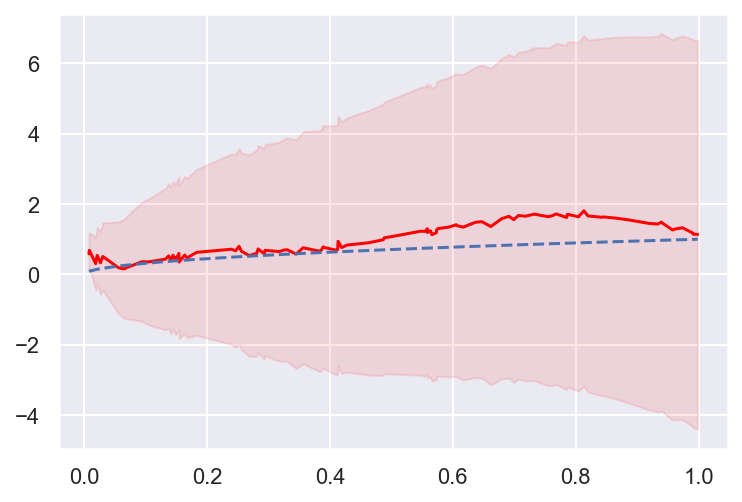

In [91]:
fig, ax = plt.subplots()
ax.fill_between(X, 
                 f + 1.96 * f_std, 
                 f - 1.96 * f_std,
                 color='red', alpha=0.1)
ax.plot(X, f, color='red')
ax.plot(X, u_model(X, theta_model), ls='--');

### Using linear prior

In [60]:
u_model = u_lin
theta_model = None
tau_model = 3.333

use_ratio = True

## Sparse

In [93]:
def sparse_model(X, y, p, undo_sorted, u, theta, tau, T=50, jitter=1e-06):
    
    n = y.shape[0]
    
    def objective(param):

        var = softplus(param[0])
        length = sofplus(param[1])
        eta = param[2:]
        
        Xt = np.linspace(0, 1, T)
        
        Mt = u(Xt, theta)
        K_factor = Mt[:, None] * Mt

        k_XX = K_factor * var **2 * kernel(Xt, Xt, length) + jitter*np.eye(T)
        L = np.linalg.cholesky(k_XX)
        L_dot_eta = np.dot(L, eta)
        # f = Mt + L_dot_eta

        Mp = jnp.asarray(u(X, theta))
        K_Xp_factor = Mt[:, None] * Mp

        K_Xp = K_Xp_factor * var**2 * kernel(Xt, X, length)
        A = jax.scipy.linalg.solve_triangular(L, K_Xp, lower=True)
        v = jax.scipy.linalg.solve_triangular(L, L_dot_eta, lower=True)

        f_predict = Mp + A.T.dot(v)

        est_eu_sorted =  p * f_predict    
        est_eu = est_eu_sorted[undo_sorted]
        est_diff_eu = est_eu[n:] - est_eu[:n]
    
        p_y = scipy.special.expit(tau*est_diff_eu)
        log_p = np.log(p_y**y * (1-p_y)**(1-y) + np.finfo(float).eps).sum()
        
        return - log_p
        #numpyro.sample("obs", dist.Bernoulli(logits=), obs=y)
    
    return objective

In [94]:
def run_inference_sparse(data, u, theta, tau, use_ratio):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    X = x_sorted
    uX = u(X, theta)
    P = p_sorted

    M = uX
    
    if use_ratio:
        factor = uX[:, None] * uX
    else:
        factor = 1.
        
    res = scipy.optimize.minimize(
        model(X=X, p=P, y=y, tau=tau, factor=factor, M=M, undo_sorted=undo_sorted),
        x0=np.zeros(2+len(X)))
    
    opt_var = sofplus(res.x[0])
    opt_length = sofplus(res.x[1])
    opt_eta = res.x[2:]
    
    return X, opt_var, opt_length, opt_eta

In [96]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=200, replace=False)

optimize(data, u_m=u_pow)

array([3.59802122, 0.36180301])

In [97]:
u_model = u_pow
theta_model = 0.5
tau_model = 3.333

use_ratio = True

In [98]:
%%time
X, var, length, eta = run_inference_sparse(
    data=data, 
    u=u_model, theta=theta_model, tau=tau_model,
    use_ratio=use_ratio)

CPU times: user 1h 7min 10s, sys: 9min 13s, total: 1h 16min 23s
Wall time: 19min 49s


In [99]:
f, f_std = gp_predict(X=X, var=var, length=length, eta=eta, u=u_model, theta=theta_model, use_ratio=use_ratio)

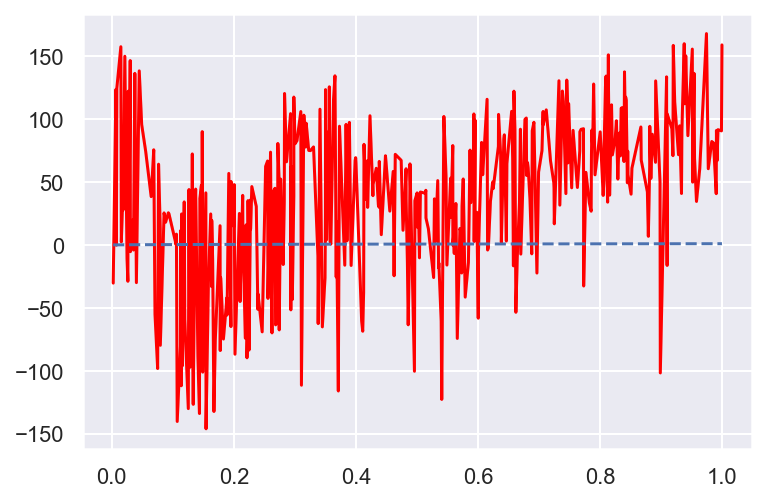

In [100]:
fig, ax = plt.subplots()
ax.fill_between(X, 
                 f + 1.96 * f_std, 
                 f - 1.96 * f_std,
                 color='red', alpha=0.1)
ax.plot(X, f, color='red')
ax.plot(X, u_model(X, theta_model), ls='--');